In [1]:
from aeon.classification.convolution_based import HydraClassifier, Arsenal, RocketClassifier, MultiRocketHydraClassifier
import numpy as np
import pandas as pd
import glob
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

c:\Users\student\anaconda3\envs\timeseries\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


Functions Defined

In [2]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

Loading, assign label and combine video id with keypoints

In [3]:
# Load data for different categories
male_directory = 'C:/Users/student/Desktop/Time Series Analysis/Gender_Prediction/P_dataset/male'
female_directory = 'C:/Users/student/Desktop/Time Series Analysis/Gender_Prediction/P_dataset/female'   

female_data = load_data(female_directory, start_video_id=1)
male_data = load_data(male_directory, start_video_id=190)

# Assign labels
female_data['label'] = 1
male_data['label'] = 2

# Combine data
data = pd.concat([female_data, male_data])

# Merge keypoints by video_id
grouped_data = data.groupby('video_id').agg({'keypoints': 'sum', 'label': 'first'}).reset_index()

Convert data format and showing class distribution

In [4]:
# Split features and labels
X = grouped_data['keypoints']
y = grouped_data['label']

# Convert keypoints to numpy arrays and pad sequences to the same length
X = np.array([np.pad(np.array(kp), (0, max(map(len, X)) - len(kp)), 'constant') for kp in X])

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=101)

# Convert the input data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert the one-hot encoded y_train to dense array and reshape
y_train_dense = y_train.argmax(axis=1)

# Check the class distribution before oversampling
print(f"Class distribution before oversampling: {Counter(y_train_dense)}")

Class distribution before oversampling: Counter({1: 204, 0: 147})


P Dataset - Gender Prediction

Hydra Classifier

Accuracy: 0.5568181818181818


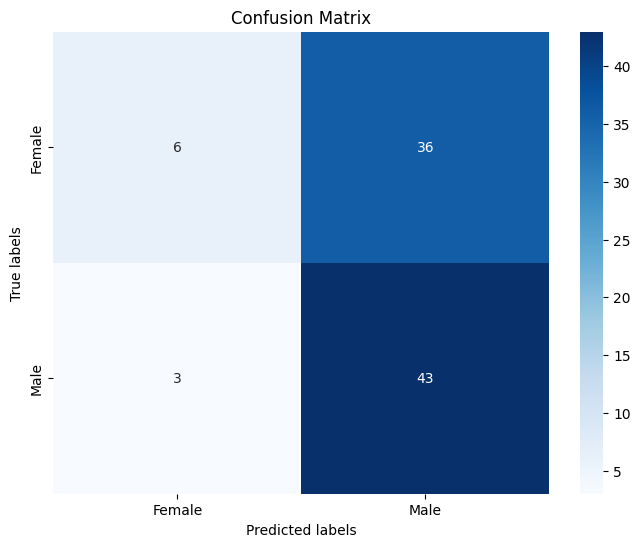

Classification Report:
               precision    recall  f1-score   support

      Female       0.67      0.14      0.24        42
        Male       0.54      0.93      0.69        46

    accuracy                           0.56        88
   macro avg       0.61      0.54      0.46        88
weighted avg       0.60      0.56      0.47        88



In [5]:
# Training on Hydra Classifier
classifier =  HydraClassifier(n_kernels=2, n_groups=8, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train_dense)

# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Female', 'Male'])
print("Classification Report:\n", class_report)


Rocket Classifier

Accuracy: 0.5454545454545454


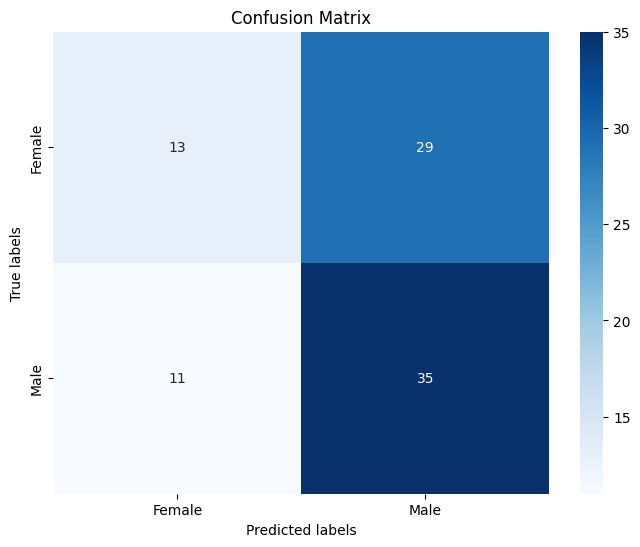

Classification Report:
               precision    recall  f1-score   support

      Female       0.54      0.31      0.39        42
        Male       0.55      0.76      0.64        46

    accuracy                           0.55        88
   macro avg       0.54      0.54      0.52        88
weighted avg       0.54      0.55      0.52        88



In [7]:
# Training on Rocket Classifier
classifier =  RocketClassifier(num_kernels=10000, rocket_transform='minirocket', max_dilations_per_kernel=32, 
                               n_features_per_kernel=4, estimator=None, random_state=42, n_jobs=1)
classifier.fit(X_train, y_train_dense)


# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Female', 'Male'])
print("Classification Report:\n", class_report)


MultiRocketHydraClassifier

Accuracy: 0.5795454545454546


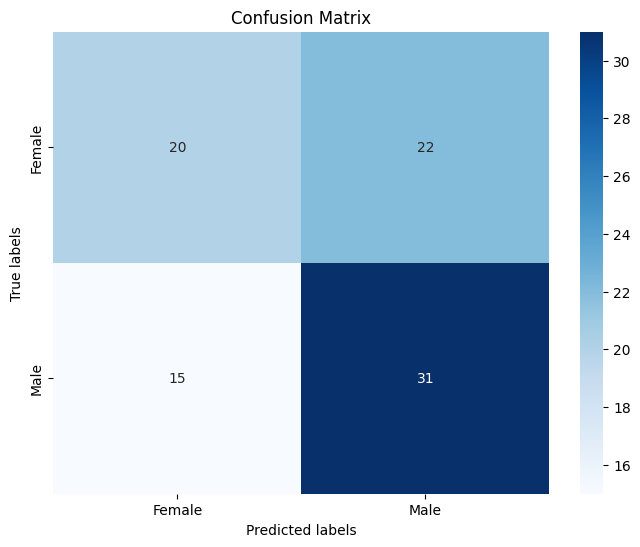

Classification Report:
               precision    recall  f1-score   support

      Female       0.57      0.48      0.52        42
        Male       0.58      0.67      0.63        46

    accuracy                           0.58        88
   macro avg       0.58      0.58      0.57        88
weighted avg       0.58      0.58      0.58        88



In [6]:
# Training on MultiRocketHydra Classifier
classifier =  MultiRocketHydraClassifier(n_kernels=2, n_groups=8, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train_dense)


# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Female', 'Male'])
print("Classification Report:\n", class_report)
